**Aim** :
Banks need to put proactive monitoring and fraud prevention mechanisms in place to reduce the unauthorised transactions. We need to develop a machine learning model to detect fraudulent transactions based on the historical transactional data of customers with a pool of merchants.

Flow of Analysis :
1. Import the required libraries
2. Read and understand the data
3. Data cleanup and preparation
4. Exploratory Data Analysis
5. Model building
6. Hyperparameters Tuning
7. Cost Benefit Analysis



# Import Libraries




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

In [ ]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [ ]:
# Adjusting the display to fit rows and columns effectively
start_time = time.time()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
from datetime import datetime, date
import math
from math import radians, sin, cos, acos, atan2
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies /fraudTrain.csv')


In [ ]:
data_train.shape

(1296675, 23)

In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies /fraudTest.csv')


In [ ]:
data_test.shape

(555719, 23)

In [ ]:
# Checking for duplicates and deleteing the duplicate records. 

data_train.drop_duplicates()
data_test.drop_duplicates()

print(data_train.shape)
print(data_test.shape)

In [ ]:
# Checking the fields and their datatypes. 

data_train.info(verbose=True) # We see that there are no null values

In [ ]:
data_test.info(verbose=True) # We see that there are no null values


In [ ]:
# Check statistical information abut numerical fields.

data_train.describe()


# Data Cleaning and Preparation 

In [ ]:
data_train['is_fraud'].value_counts(normalize=True) # check the class imbalance of target variable is_fraud in train set


0    0.994211
1    0.005789
Name: is_fraud, dtype: float64

In [ ]:
# 1= fraud , 0= Non fraud

In [ ]:
data_test['is_fraud'].value_counts(normalize=True) # check the class imbalance of target variable is_fraud in train set


0    0.99614
1    0.00386
Name: is_fraud, dtype: float64

In [ ]:
#Using data_tain 

data_train.isnull().sum().sort_values()


In [ ]:
# Dropping unwanted columns

cols_to_delete = ['Unnamed: 0', 'cc_num', 'street', 'zip', 'trans_num', 'unix_time' ] 
data_train.drop(cols_to_delete, axis = 1, inplace = True)

In [ ]:
# Create a column customer name with columns first and last 

data_train['Customer_name'] = data_train['first']+" "+data_train['last']
data_train.drop(['first','last'], axis=1, inplace=True)

In [ ]:
data_train.info()


In [ ]:
# Analyse city_pop variable

print("Min population : ", data_train['city_pop'].min())
print("Max population : ", data_train['city_pop'].max())

Min population :  23
Max population :  2906700


In [ ]:
data_train["Population_group"] = pd.cut(data_train["city_pop"], bins=list(range(0,3000001,500000)), labels = ["<5lac","5-10lac","10-15lac","15-20","20-25lac","25-30lac"])


In [ ]:
data_train["Population_group"].value_counts()


<5lac       1230966
5-10lac       32895
10-15lac      14882
15-20         11210
25-30lac       6201
20-25lac        521
Name: Population_group, dtype: int64

In [ ]:
# Create a column age from dob variable

data_train['dob'] = pd.to_datetime(data_train['dob'])

In [ ]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [ ]:
 #Create a column age
data_train['age'] = data_train["dob"].apply(calculate_age)

In [ ]:
# Create a column age_group from the column age
data_train["age_group"] = pd.cut(data_train["age"], bins=[0,25,40,60,80,9999], labels = ["<25","25-40","40-60","60-80","80+"])

In [ ]:
#pip install mpu --user

In [ ]:
# Calculating distance using customer co-ordinates and merchant co-ordinates
#import mpu


#data['distance'] = mpu.haversine_distance((data['merch_lat'], data['merch_long']), (data['lat'], data['long']))

In [ ]:
# Calculating distance between the customer and merchant location using customer location co-ordinates(lat and long) 
# and merchant location co-ordinates(merch_lat and merch_long)

R = 6373.0  # radius of the Earth

data_train['lat'] = data_train['lat'].astype('float')
data_train['long'] = data_train['long'].astype('float')
data_train['merch_lat'] = data_train['merch_lat'].astype('float')
data_train['merch_long'] = data_train['merch_long'].astype('float')#coordinates

In [ ]:
data_train['lat'] = np.radians(data_train['lat'])
data_train['long'] = np.radians(data_train['long'])
data_train['merch_lat'] = np.radians(data_train['merch_lat'])
data_train['merch_long'] = np.radians(data_train['merch_long'])

In [ ]:
data_train['dlon'] = data_train['merch_long'] - data_train['long'] #change in coordinates
data_train['dlat'] = data_train['merch_lat'] - data_train['lat']

In [ ]:
a = np.sin(data_train['dlat'] / 2)**2 + np.cos(data_train['lat']) * np.cos(data_train['merch_lat']) * np.sin(data_train['dlon'] / 2)**2  #Haversine formula


In [ ]:
c = 2*2*np.arctan2(np.sqrt(a), np.sqrt(1 - a))
data_train['distance'] = R * c

In [ ]:
data_train['distance'].head()


In [ ]:
data_train['distance'].describe()


In [ ]:
data_train["dist_range_km"] = pd.cut(data_train["distance"], bins=[0,25,50,100,150,200,250,300,9999], labels = ["<25","25-50","50-100","100-150","150-200","200-250","250-300","300+"])


In [ ]:
data_train.head()


In [ ]:
data_train.drop(['dlat', 'dlon', 'dob','city_pop'], axis=1, inplace=True)

In [ ]:
data_train.info()


In [ ]:
data_train['trans_date_trans_time'] = pd.to_datetime(data_train['trans_date_trans_time'])


In [ ]:
# Extract year and month from trans_date_trans_time column

data_train['year'] = pd.DatetimeIndex(data_train['trans_date_trans_time']).year
data_train['month'] = pd.DatetimeIndex(data_train['trans_date_trans_time']).month

In [ ]:
# Extract day of the week and transaction hour from trans_date_trans_time column

data_train['day_of_week'] = data_train['trans_date_trans_time'].dt.day_name()
data_train['transaction_hour'] = data_train['trans_date_trans_time'].dt.hour

# Exploratory Data Analysis

# Univariate Analysis



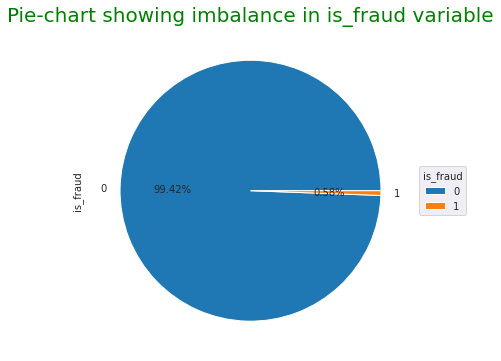

In [ ]:
# TARGET variable is_fraud

plt.figure(figsize= (10,6))
fig = data_train["is_fraud"].value_counts(normalize = True).plot.pie(autopct='%1.2f%%')
plt.title("Pie-chart showing imbalance in is_fraud variable", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
fig.legend(title="is_fraud",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Inference : As we can see, the dataset is imbalanced with 0.58% of transactions being fraudulent and 99.42% transactions being non-fraudulent



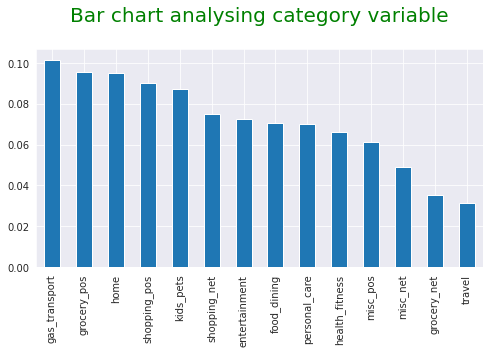

In [ ]:
# Category variable 

plt.figure(figsize= (8,4))
data_train["category"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing category variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

Inference : Maximum transactions in the dataset belong to merchants falling in gas_transport category and least being travel category.



In [ ]:
# gender variable 

plt.figure(figsize= (8,4))
data_train["gender"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing gender variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

In [ ]:
# Population_group variable 

plt.figure(figsize= (12,8))
data_train["state"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing state variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

In [ ]:
plt.figure(figsize= (10,6))
data_train["Population_group"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing Population_group variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

In [ ]:
# age_group variable

plt.figure(figsize= (10,6))
data_train["age_group"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing age_group variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

In [ ]:
# year variable

plt.figure(figsize= (10,6))
data_train["year"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing year variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

In [ ]:
# month variable

plt.figure(figsize= (10,6))
data_train["month"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing month variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

In [ ]:
# day_of_week variable

plt.figure(figsize= (10,6))
data_train["day_of_week"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing day_of_week variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

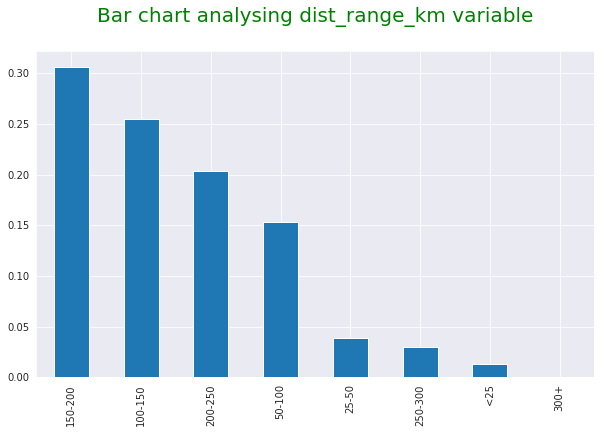

In [ ]:
# dist_range_km variable

plt.figure(figsize= (10,6))
data_train["dist_range_km"].value_counts(normalize = True).plot.bar()
plt.title("Bar chart analysing dist_range_km variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

# Bi-Variate analysis

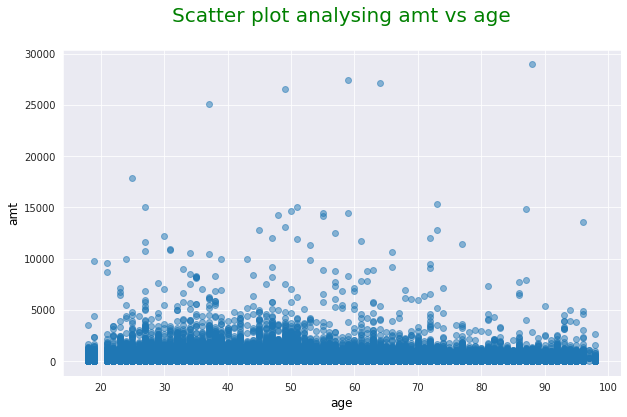

In [ ]:
# amt vs age

plt.figure(figsize= [10,6])
plt.scatter(data_train["age"], data_train["amt"], alpha = 0.5)
plt.title("Scatter plot analysing amt vs age\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("age", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("amt", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

In [ ]:
fraud_data = data_train[data_train['is_fraud']==1]


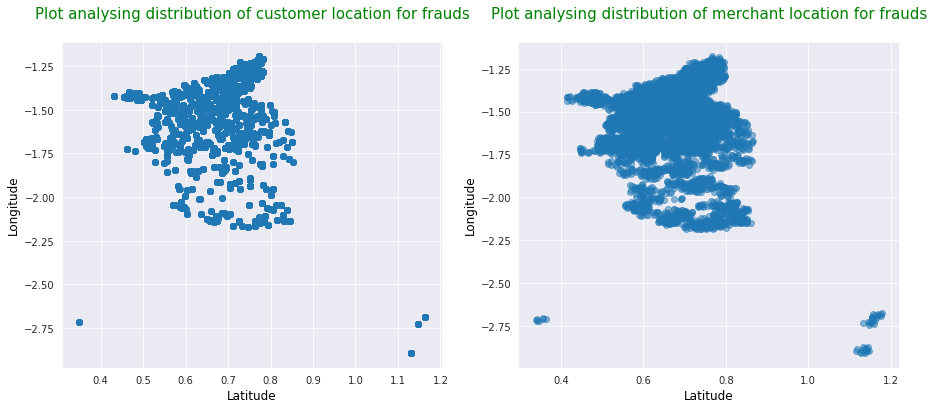

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(fraud_data["lat"], fraud_data["long"], alpha = 0.5)
plt.title("Plot analysing distribution of customer location for frauds\n", fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Longitude", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.xlabel("Latitude", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})

plt.subplot(1,2,2)
plt.scatter(fraud_data["merch_lat"], fraud_data["merch_long"], alpha = 0.5)
plt.title("Plot analysing distribution of merchant location for frauds\n", fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Longitude", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.xlabel("Latitude", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})

plt.show()

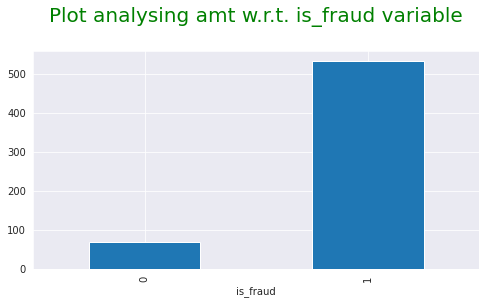

In [ ]:
# is_fraud and amt

plt.figure(figsize= (8,4))
data_train.groupby("is_fraud")["amt"].mean().plot.bar()
plt.title("Plot analysing amt w.r.t. is_fraud variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

In [ ]:
# is_fraud and age

plt.figure(figsize= (8,4))
data_train.groupby("is_fraud")["age"].mean().plot.bar()
plt.title("Plot analysing age w.r.t. is_fraud variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

Inference: On an average more people in 40-50 years age group have done fraudulent transactions than genuine transactions.



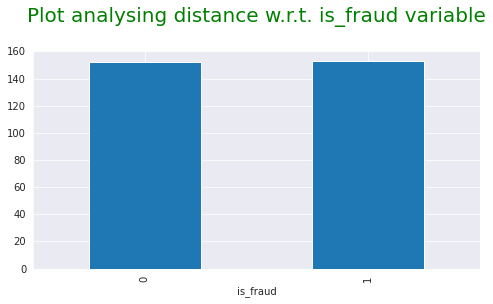

In [ ]:
# is_fraud and distance

plt.figure(figsize= (8,4))
data_train.groupby("is_fraud")["distance"].mean().plot.bar()
plt.title("Plot analysing distance w.r.t. is_fraud variable\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

plt.show()

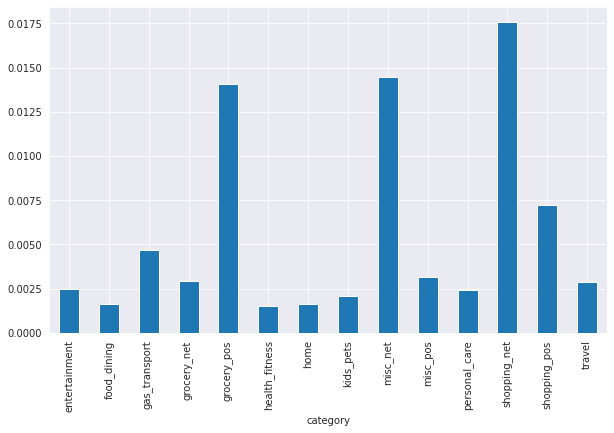

In [ ]:
# category and is_fraud

plt.figure(figsize= (10,6))
data_train.groupby("category")["is_fraud"].mean().plot.bar()
plt.show()

Inference : Maximim fraudulent transactions are performed at merchants with category shopping_net



In [ ]:
# gender and is_fraud

plt.figure(figsize= (8,6))
data_train.groupby("gender")["is_fraud"].mean().plot.bar()
plt.show()

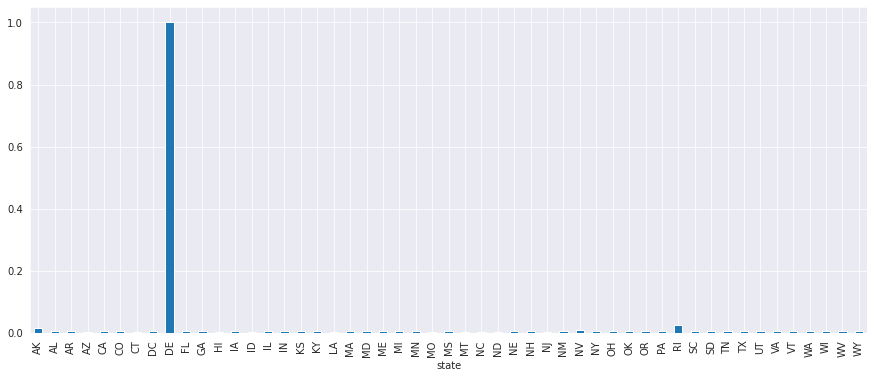

In [ ]:
# state and is_fraud

plt.figure(figsize= (15,6))
data_train.groupby("state")["is_fraud"].mean().plot.bar()
plt.show()

Inference: Surprisingly, most of the transactions performed in Deleware (DE) are fraudulent, even though the number of actual transaction performed in Delaware(DE) are the least amongst all the states



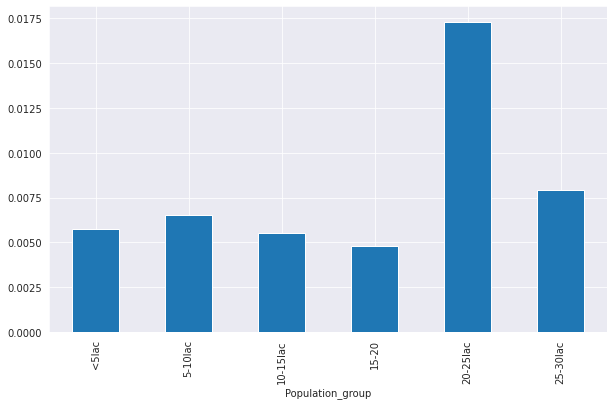

In [ ]:
# Population_group and is_fraud

plt.figure(figsize= (10,6))
data_train.groupby("Population_group")["is_fraud"].mean().plot.bar()
plt.show()

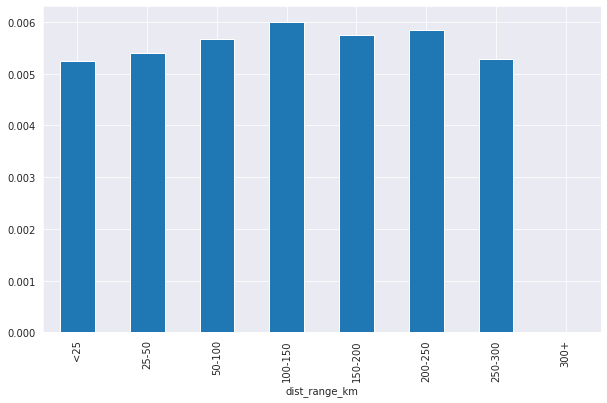

In [ ]:
# dist_range_km and is_fraud

plt.figure(figsize= (10,6))
data_train.groupby("dist_range_km")["is_fraud"].mean().plot.bar()
plt.show()

# Multivariate Analysis

In [ ]:
#category v/s gender Type v/s is_fraud
pivot1 = pd.pivot_table(data = data_train, index = "gender", columns = "category", values = "is_fraud")
pivot1

category,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
gender,,,,,,,,,,,,,,
F,0.003030,0.002397,0.003509,0.002255,0.011481,0.002475,0.002757,0.003022,0.010999,0.003894,0.002933,0.012397,0.006737,0.003280
M,0.001899,0.000813,0.006153,0.003816,0.017037,0.000517,0.000311,0.000977,0.018916,0.002280,0.001632,0.024332,0.007903,0.002453


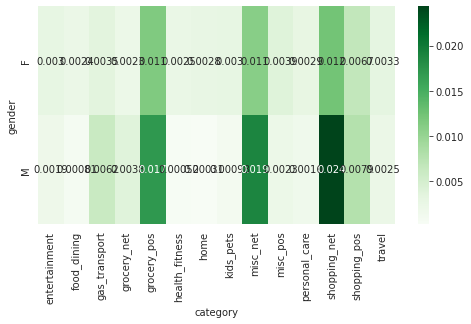

In [ ]:
plt.figure(figsize= (8,4))
sns.heatmap(pivot1, cmap = "Greens", annot = True)
plt.show()

Inference: Most fraudulent transactions are performed by males in the category shopping_net



In [ ]:
#state v/s gender Type v/s is_fraud
pivot2 = pd.pivot_table(data = data_train, index = "state", columns = "gender", values = "is_fraud")
pivot2

In [ ]:
plt.figure(figsize= (10,15))
sns.heatmap(pivot2, cmap = "Greens", annot = True)
plt.show()

Inference : 100% transactions performed in the states DE and NV are performed by females and are fraudulent.



In [ ]:
#age_group v/s gender Type v/s is_fraud
pivot3 = pd.pivot_table(data = data_train, index = "age_group", columns = "gender", values = "is_fraud")
pivot3

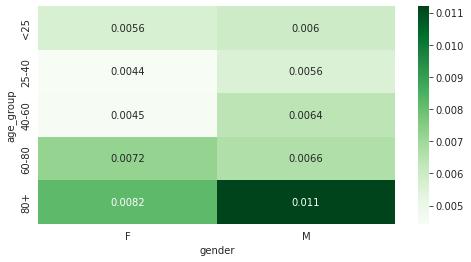

In [ ]:
plt.figure(figsize= (8,4))
sns.heatmap(pivot3, cmap = "Greens", annot = True)
plt.show()

Inference : Transactions performed by 80+ years males are may be fraudulent.



In [ ]:
#Population_group v/s dist_range_km Type v/s is_fraud
pivot4 = pd.pivot_table(data = data_train, index = "dist_range_km", columns = "Population_group", values = "is_fraud")
pivot4


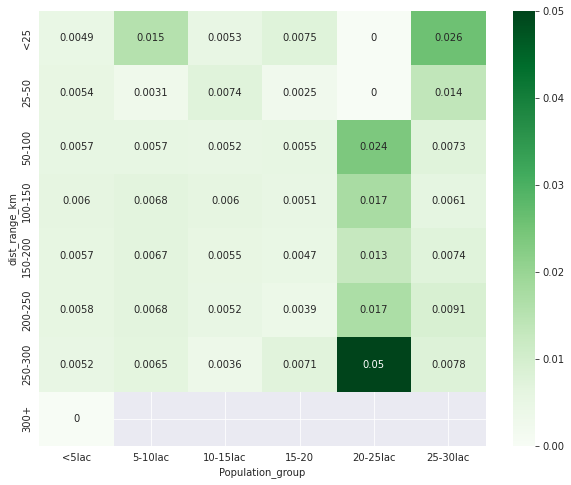

In [ ]:
plt.figure(figsize= (10,8))
sns.heatmap(pivot4, cmap = "Greens", annot = True)
plt.show()

Inference : There should be a check on transactions performed at a distance of 250-300 kms from customer location in areas with population range 20-25 lacs



In [ ]:
#year v/s month Type v/s is_fraud
pivot5 = pd.pivot_table(data = data_train, index = "month", columns = "year", values = "is_fraud")
pivot5

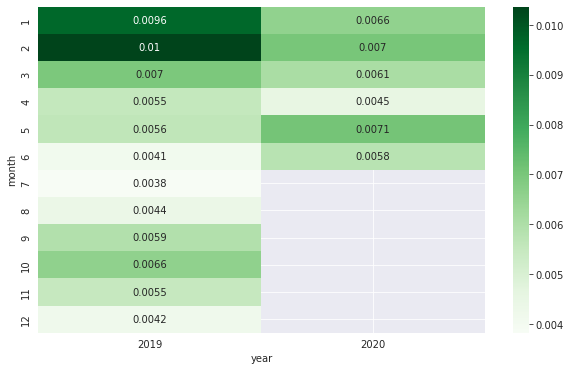

In [ ]:
plt.figure(figsize= (10,6))
sns.heatmap(pivot5, cmap = "Greens", annot = True)
plt.show()

Inference : Most fraudulent transactions are performed in Jan and Feb 2019.



In [ ]:
#age_group v/s dist_range_km Type v/s is_fraud
pivot6 = pd.pivot_table(data = data_train, index = "age_group", columns = "dist_range_km", values = "is_fraud")
pivot6

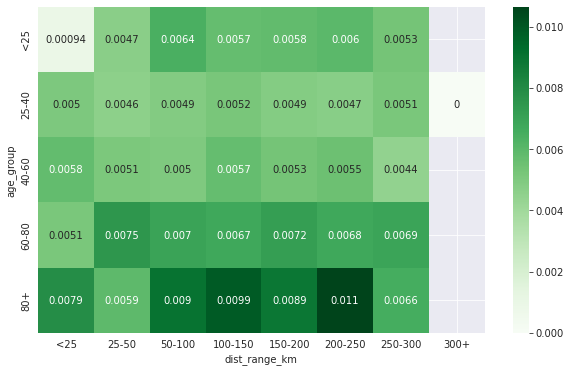

In [ ]:
plt.figure(figsize= (10,6))
sns.heatmap(pivot6, cmap = "Greens", annot = True)
plt.show()

Inference: Transactions performed by 80+ ages customers at a distance of 200-250 kms from customer location should be scrutinized as they indicate fraud



In [ ]:
#transaction_hour v/s dist_range_km Type v/s is_fraud
pivot9 = pd.pivot_table(data = data_train, index = "transaction_hour", columns = "dist_range_km", values = "is_fraud")
pivot9

In [ ]:
plt.figure(figsize= (10,6))
sns.heatmap(pivot9, cmap = "Greens", annot = True)
plt.show()

Inference : Transactions performed at odd hours irrespective of distance from customer location indicate fraud



# Check Skewness in data 

In [ ]:
data_train.describe()


In [ ]:
cols = ['amt', 'age', 'distance']


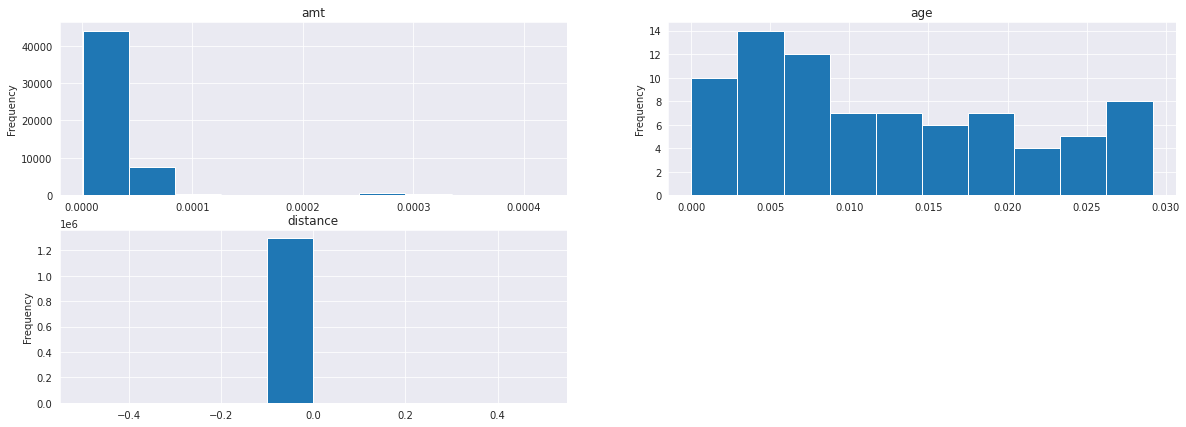

In [ ]:
plt.figure(figsize=[20,7])
for ind, col in enumerate(cols):
    plt.subplot(2,2,ind+1)
    data_train[col].value_counts(normalize=True).plot.hist()
    plt.title(col)
plt.show()

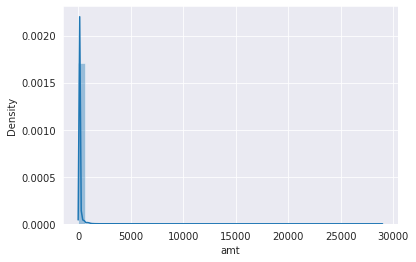

In [ ]:
sns.distplot(data_train.amt)
plt.show()

Inference : We can see that amt variable is skewed.



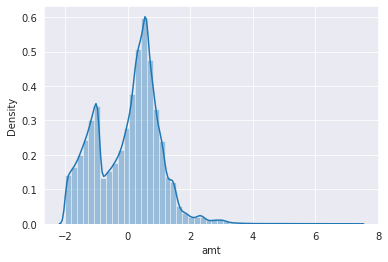

In [ ]:
# Applying Power Transaformation

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()

data_train['amt'] = pt.fit_transform(data_train[['amt']])

sns.distplot(data_train.amt)
plt.show()

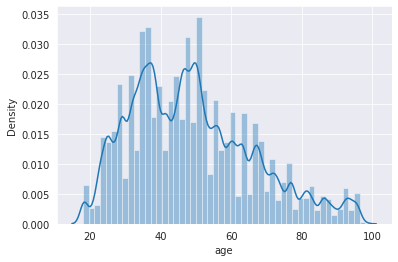

In [ ]:
sns.distplot(data_train.age)
plt.show()

# Model building

In [ ]:
data_train.info()


In [ ]:
data_train.merchant.value_counts()


In [ ]:
data_train.job.value_counts()


In [ ]:
len(data_train.job.value_counts())


494

Removing Unwanted columns

In [ ]:
data_train.drop(['trans_date_trans_time', "lat", "long", "merch_lat", "merch_long", "Customer_name", "year"], axis=1, inplace=True)


In [ ]:
data_train.drop(["merchant", "city", "job"], axis=1, inplace=True)


In [ ]:
data_train.info()


# Train Test Split



In [ ]:
#Peform the train test split 
train,test = train_test_split(data_train,test_size=0.3,random_state=42, stratify=data_train.is_fraud)


In [ ]:
# check the training and testing data shape
print(f"train data shape:{train.shape}")
print(f"Test data shape:{test.shape}")

train data shape:(907672, 13)
Test data shape:(389003, 13)


In [ ]:
train.is_fraud.value_counts(normalize=True)


0    0.994212
1    0.005788
Name: is_fraud, dtype: float64

In [ ]:
test.is_fraud.value_counts(normalize=True)


0    0.994211
1    0.005789
Name: is_fraud, dtype: float64

In [ ]:
# segregate  X_train and y_train 
y_train = train.pop("is_fraud")
X_train = train

In [ ]:
# Segregate X_test and y_test
y_test = test.pop("is_fraud")
X_test = test

In [ ]:
X_train.head()


# Creating Dummy variables

In [ ]:
X_train['transaction_hour']= X_train['transaction_hour'].astype(str)
X_train['month']= X_train['month'].astype(str)



In [ ]:
X_test['transaction_hour']= X_test['transaction_hour'].astype(str)

X_test['month']= X_test['month'].astype(str)

In [ ]:
data_train.info()


In [ ]:
cat_cols = ["category", "state", "month", "day_of_week", "transaction_hour", 'gender', 'Population_group','age_group', 'dist_range_km']


In [ ]:
dummy = pd.get_dummies(X_train[cat_cols], drop_first=True)


In [ ]:
# Adding the results to the master dataframe
X_train = pd.concat([X_train, dummy], axis=1)

In [ ]:
X_train.drop(cat_cols, axis=1, inplace=True)


In [ ]:
X_train.head()


In [ ]:
X_train.drop(['age','distance'], axis=1, inplace=True)


In [ ]:
scaler = MinMaxScaler()

scale_var = ["amt"]

X_train[scale_var] = scaler.fit_transform(X_train[scale_var])  # Scaling of train set 


In [ ]:
X_train.describe()  # Check if scaling is proper


Dummy variable creation for X_test

In [ ]:
dummy1 = pd.get_dummies(X_test[cat_cols], drop_first=True)

# Adding the results to the master dataframe
X_test = pd.concat([X_test, dummy1], axis=1)

X_test.drop(cat_cols, axis=1, inplace=True)

In [ ]:
X_test.drop(['age','distance'], axis=1, inplace=True)


In [ ]:
X_test[scale_var] = scaler.transform(X_test[scale_var])


In [ ]:
#Check heatmap for correlation

plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr())
plt.show()

In [ ]:
# check the training and testing data shape
print(f"train data shape:{X_train.shape}")
print(f"Test data shape:{X_test.shape}")

train data shape:(907672, 121)
Test data shape:(389003, 121)


# feature selction 

In [ ]:
# run random forest to get feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 25).fit(X_train, y_train)

feats = X_train.columns

for feature in zip(feats, rf.feature_importances_):
    print(feature)

In [ ]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_
})

In [ ]:
imp_df.sort_values(by="Imp", ascending=False)


In [ ]:
cols_for_model = ['amt', 'category_grocery_pos', 'transaction_hour_22', 'transaction_hour_23', 'category_gas_transport',
                 'age_group_60-80', 'gender_M', 'age_group_25-40', 'age_group_40-60', 'category_misc_net', 'dist_range_km_150-200',
                 'category_misc_pos', 'category_shopping_net', 'dist_range_km_100-150', 'day_of_week_Sunday', 'dist_range_km_200-250',
                 'category_shopping_pos', 'age_group_80+', 'day_of_week_Saturday']

In [ ]:
X_train = X_train[cols_for_model]


In [ ]:
X_test = X_test[cols_for_model]


In [ ]:
X_train.columns


Index(['amt', 'category_grocery_pos', 'transaction_hour_22', 'transaction_hour_23', 'category_gas_transport', 'age_group_60-80', 'gender_M', 'age_group_25-40', 'age_group_40-60', 'category_misc_net', 'dist_range_km_150-200', 'category_misc_pos', 'category_shopping_net', 'dist_range_km_100-150', 'day_of_week_Sunday', 'dist_range_km_200-250', 'category_shopping_pos', 'age_group_80+', 'day_of_week_Saturday'], dtype='object')

# Handling Imbalance class


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [ ]:
# check the training and testing data shape
print(f"train data shape:{X_train.shape}")
print(f"Test data shape:{X_test.shape}")

train data shape:(907672, 19)
Test data shape:(389003, 19)


In [ ]:
print(y_train.value_counts())
y_train.value_counts(normalize = True).reset_index()

In [ ]:
print(y_test.value_counts())
y_test.value_counts(normalize = True).reset_index()


# Logistic Regression



In [ ]:
# Base model
lreg = LogisticRegression()
lreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = lreg.predict(X_test)


In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred))
print ('F1 score: ', f1_score(y_test, y_pred))
print ('Recall: ', recall_score(y_test, y_pred))
print ('Precision: ', precision_score(y_test, y_pred))
print ('\n clasification report:\n', classification_report(y_test,y_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))


Accuracy:  0.9955990056631954
F1 score:  0.438688524590164
Recall:  0.29706927175843695
Precision:  0.8383458646616542

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.84      0.30      0.44      2252

    accuracy                           1.00    389003
   macro avg       0.92      0.65      0.72    389003
weighted avg       1.00      1.00      0.99    389003


 confussion matrix:
 [[386622    129]
 [  1583    669]]


We can handle imbalanced classes by balancing the classes by increasing minority or decreasing majority.

We can do that by following few techniques

Random Under-Sampling
Random Over-Sampling
SMOTE - Synthetic Minority Oversampling Technique
ADASYN - Adaptive Synthetic Sampling Method
SMOTETomek - Over-sampling followed by under-sampling
Unddersampling tends to loss of data so we will not use that. We will go with Random Over-Sampling, SMOTE - Synthetic Minority Oversampling Technique, ADASYN - Adaptive Synthetic Sampling Method and see which technique works better.

In [ ]:
pip install imbalanced-learn


Random Over-Sampling

Randomly add more minority observations by replication
No information loss
Prone to overfitting due to copying same information


In [ ]:
# Random OverSampling
from imblearn.over_sampling import RandomOverSampler
over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train, y_train)
len(X_resampled_os)

1804836

In [ ]:
from collections import Counter
print(sorted(Counter(y_resampled_os).items()))

[(0, 902418), (1, 902418)]


In [ ]:
lreg_os = LogisticRegression()
lreg_os.fit(X_resampled_os, y_resampled_os)

y_pred_os = lreg_os.predict(X_test)


In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_os))
print ('F1 score: ', f1_score(y_test, y_pred_os))
print ('Recall: ', recall_score(y_test, y_pred_os))
print ('Precision: ', precision_score(y_test, y_pred_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_os))

Accuracy:  0.7671534666827762
F1 score:  0.03906216847018884
Recall:  0.8174955595026643
Precision:  0.02000912964090079

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87    386751
           1       0.02      0.82      0.04      2252

    accuracy                           0.77    389003
   macro avg       0.51      0.79      0.45    389003
weighted avg       0.99      0.77      0.86    389003


 confussion matrix:
 [[296584  90167]
 [   411   1841]]


SMOTE - Synthetic Minority Oversampling Technique Creates new "Synthetic" observations

Process: -

Identify the feature vector and its nearest neighbour
Take the difference between the two
Multiply the difference with a random number between 0 and 1
Identify a new point on the line segment by adding the random number to feature vector
Repeat the process for identified feature vectors

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=45, k_neighbors=5)
X_resampled_smt, y_resampled_smt = smt.fit_resample(X_train, y_train)
len(X_resampled_smt)

1804836

In [ ]:
print(sorted(Counter(y_resampled_smt).items()))


[(0, 902418), (1, 902418)]


In [ ]:
lreg_smt = LogisticRegression()
lreg_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_smt = lreg_smt.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_smt))
print ('F1 score: ', f1_score(y_test, y_pred_smt))
print ('Recall: ', recall_score(y_test, y_pred_smt))
print ('Precision: ', precision_score(y_test, y_pred_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_smt))

Accuracy:  0.7747575211502225
F1 score:  0.0406639367595857
Recall:  0.8246003552397868
Precision:  0.020845962147235133

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87    386751
           1       0.02      0.82      0.04      2252

    accuracy                           0.77    389003
   macro avg       0.51      0.80      0.46    389003
weighted avg       0.99      0.77      0.87    389003


 confussion matrix:
 [[299526  87225]
 [   395   1857]]


ADASYN

In ADASYN, the minority examples are generated based on their density distribution.
More synthetic data are generated from minority class samples that are harder to learn as compared with those minority samples that are easier to learn.

In [ ]:
# ADASYN
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=45, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
len(X_resampled_ada)

1805572

In [ ]:
print(sorted(Counter(y_resampled_ada).items()))


[(0, 902418), (1, 903154)]


In [ ]:
lreg_ada = LogisticRegression()
lreg_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_ada = lreg_ada.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_ada))
print ('F1 score: ', f1_score(y_test, y_pred_ada))
print ('Recall: ', recall_score(y_test, y_pred_ada))
print ('Precision: ', precision_score(y_test, y_pred_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_ada))

Accuracy:  0.8359652753320669
F1 score:  0.050050616328232
Recall:  0.7464476021314387
Precision:  0.02589340727048675

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    386751
           1       0.03      0.75      0.05      2252

    accuracy                           0.84    389003
   macro avg       0.51      0.79      0.48    389003
weighted avg       0.99      0.84      0.91    389003


 confussion matrix:
 [[323512  63239]
 [   571   1681]]


# Decision Trees

In [ ]:
# Decision Trees - Base
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc))
print ('F1 score: ', f1_score(y_test, y_pred_dtc))
print ('Recall: ', recall_score(y_test, y_pred_dtc))
print ('Precision: ', precision_score(y_test, y_pred_dtc))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc))

Accuracy:  0.9963239358051224
F1 score:  0.6866783523225242
Recall:  0.6958259325044405
Precision:  0.6777681660899654

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.68      0.70      0.69      2252

    accuracy                           1.00    389003
   macro avg       0.84      0.85      0.84    389003
weighted avg       1.00      1.00      1.00    389003


 confussion matrix:
 [[386006    745]
 [   685   1567]]


In [ ]:
# Decision Trees - Random Over-Sampling
from sklearn.tree import DecisionTreeClassifier
dtc_os = DecisionTreeClassifier(random_state=0)
dtc_os.fit(X_resampled_os, y_resampled_os)

y_pred_dtc_os = dtc_os.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_os))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_os))
print ('Recall: ', recall_score(y_test, y_pred_dtc_os))
print ('Precision: ', precision_score(y_test, y_pred_dtc_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_os))

Accuracy:  0.9964139094042976
F1 score:  0.6879892641467233
Recall:  0.6829484902309059
Precision:  0.6931050022532672

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.69      0.68      0.69      2252

    accuracy                           1.00    389003
   macro avg       0.85      0.84      0.84    389003
weighted avg       1.00      1.00      1.00    389003


 confussion matrix:
 [[386070    681]
 [   714   1538]]


In [ ]:
# Decision Trees - SMOTE
from sklearn.tree import DecisionTreeClassifier
dtc_smt = DecisionTreeClassifier(random_state=0)
dtc_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_dtc_smt = dtc_smt.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_smt))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_smt))
print ('Recall: ', recall_score(y_test, y_pred_dtc_smt))
print ('Precision: ', precision_score(y_test, y_pred_dtc_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_smt))

Accuracy:  0.9543576784754874
F1 score:  0.17407080057682464
Recall:  0.8308170515097691
Precision:  0.0972200571577033

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    386751
           1       0.10      0.83      0.17      2252

    accuracy                           0.95    389003
   macro avg       0.55      0.89      0.58    389003
weighted avg       0.99      0.95      0.97    389003


 confussion matrix:
 [[369377  17374]
 [   381   1871]]


In [ ]:
# Decision Trees - ADASYN
from sklearn.tree import DecisionTreeClassifier
dtc_ada = DecisionTreeClassifier(random_state=0)
dtc_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_dtc_ada = dtc_ada.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_ada))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_ada))
print ('Recall: ', recall_score(y_test, y_pred_dtc_ada))
print ('Precision: ', precision_score(y_test, y_pred_dtc_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_ada))

Accuracy:  0.9360082055922447
F1 score:  0.13285958128679418
Recall:  0.8468028419182948
Precision:  0.07208467208467209

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    386751
           1       0.07      0.85      0.13      2252

    accuracy                           0.94    389003
   macro avg       0.54      0.89      0.55    389003
weighted avg       0.99      0.94      0.96    389003


 confussion matrix:
 [[362203  24548]
 [   345   1907]]


# Random Forest

In [ ]:
# Random Forest - Base
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf))
print ('F1 score: ', f1_score(y_test, y_pred_rf))
print ('Recall: ', recall_score(y_test, y_pred_rf))
print ('Precision: ', precision_score(y_test, y_pred_rf))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9969126202111552
F1 score:  0.7208924006507088
Recall:  0.6887211367673179
Precision:  0.7562164797659678

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.76      0.69      0.72      2252

    accuracy                           1.00    389003
   macro avg       0.88      0.84      0.86    389003
weighted avg       1.00      1.00      1.00    389003


 confussion matrix:
 [[386251    500]
 [   701   1551]]


In [ ]:
# Random Forest - Random Over-Sampling
rf_os = RandomForestClassifier()
rf_os.fit(X_resampled_os, y_resampled_os)

y_pred_rf_os = rf_os.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_os))
print ('F1 score: ', f1_score(y_test, y_pred_rf_os))
print ('Recall: ', recall_score(y_test, y_pred_rf_os))
print ('Precision: ', precision_score(y_test, y_pred_rf_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_os))

Accuracy:  0.9963624959190546
F1 score:  0.6904397287245679
Recall:  0.7007104795737122
Precision:  0.6804657179818887

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.68      0.70      0.69      2252

    accuracy                           1.00    389003
   macro avg       0.84      0.85      0.84    389003
weighted avg       1.00      1.00      1.00    389003


 confussion matrix:
 [[386010    741]
 [   674   1578]]


In [ ]:
# Random Forest - SMOTE
rf_smt = RandomForestClassifier()
rf_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_rf_smt = rf_smt.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_smt))
print ('F1 score: ', f1_score(y_test, y_pred_rf_smt))
print ('Recall: ', recall_score(y_test, y_pred_rf_smt))
print ('Precision: ', precision_score(y_test, y_pred_rf_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_smt))

Accuracy:  0.9546378819700619
F1 score:  0.173876404494382
Recall:  0.8246003552397868
Precision:  0.09718442537157211

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    386751
           1       0.10      0.82      0.17      2252

    accuracy                           0.95    389003
   macro avg       0.55      0.89      0.58    389003
weighted avg       0.99      0.95      0.97    389003


 confussion matrix:
 [[369500  17251]
 [   395   1857]]


In [ ]:
# Random Forest - ADASYN
rf_ada = RandomForestClassifier()
rf_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_rf_ada = rf_ada.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_ada))
print ('F1 score: ', f1_score(y_test, y_pred_rf_ada))
print ('Recall: ', recall_score(y_test, y_pred_rf_ada))
print ('Precision: ', precision_score(y_test, y_pred_rf_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_ada))


Accuracy:  0.9357948396284862
F1 score:  0.13060428849902533
Recall:  0.8330373001776199
Precision:  0.07085662486780481

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    386751
           1       0.07      0.83      0.13      2252

    accuracy                           0.94    389003
   macro avg       0.53      0.88      0.55    389003
weighted avg       0.99      0.94      0.96    389003


 confussion matrix:
 [[362151  24600]
 [   376   1876]]


# XGBoost

In [ ]:
from xgboost import XGBClassifier


In [ ]:
# XGBoost - Random Over-Sampling
xgb_os = XGBClassifier()
xgb_os.fit(X_resampled_os, y_resampled_os)

y_pred_xgb_os = xgb_os.predict(X_test)


In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_xgb_os))
print ('F1 score: ', f1_score(y_test, y_pred_xgb_os))
print ('Recall: ', recall_score(y_test, y_pred_xgb_os))
print ('Precision: ', precision_score(y_test, y_pred_xgb_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_xgb_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_xgb_os))

Accuracy:  0.9804345981907595
F1 score:  0.34483945941292937
Recall:  0.8894316163410302
Precision:  0.21388147357180992

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    386751
           1       0.21      0.89      0.34      2252

    accuracy                           0.98    389003
   macro avg       0.61      0.94      0.67    389003
weighted avg       0.99      0.98      0.99    389003


 confussion matrix:
 [[379389   7362]
 [   249   2003]]


In [ ]:
# XGB - SMOTE
xgb_smt = XGBClassifier()
xgb_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_xgb_smt = xgb_smt.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_xgb_smt))
print ('F1 score: ', f1_score(y_test, y_pred_xgb_smt))
print ('Recall: ', recall_score(y_test, y_pred_xgb_smt))
print ('Precision: ', precision_score(y_test, y_pred_xgb_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_xgb_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_xgb_smt))

Accuracy:  0.9667714644874204
F1 score:  0.2408973455485083
Recall:  0.9107460035523979
Precision:  0.13880617217108826

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    386751
           1       0.14      0.91      0.24      2252

    accuracy                           0.97    389003
   macro avg       0.57      0.94      0.61    389003
weighted avg       0.99      0.97      0.98    389003


 confussion matrix:
 [[374026  12725]
 [   201   2051]]


In [ ]:
# XGB - ADASYN
xgb_ada = XGBClassifier()
xgb_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_xgb_ada = xgb_ada.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_xgb_ada))
print ('F1 score: ', f1_score(y_test, y_pred_xgb_ada))
print ('Recall: ', recall_score(y_test, y_pred_xgb_ada))
print ('Precision: ', precision_score(y_test, y_pred_xgb_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_xgb_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_xgb_ada))


Accuracy:  0.9274632843448508
F1 score:  0.13025922386955582
Recall:  0.9382770870337478
Precision:  0.06998774469212679

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    386751
           1       0.07      0.94      0.13      2252

    accuracy                           0.93    389003
   macro avg       0.53      0.93      0.55    389003
weighted avg       0.99      0.93      0.96    389003


 confussion matrix:
 [[358673  28078]
 [   139   2113]]


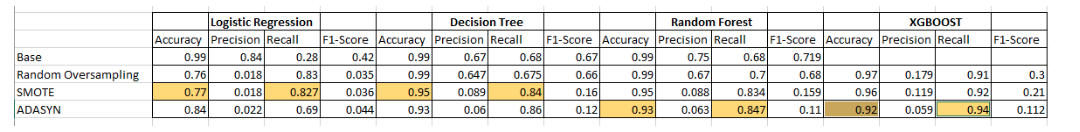

We need to fine tune the model that gives us the Best combintion of ACCURACY and RECALL. If we compare all the executed models as in above image, we see that we get a decent ACCURACY RECALL combination for the following models :

Logistic Regression SMOTE model
Decision Tree SMOTE model
XGBoost ADASYN model
Random Forest ADASYN model
Hence we perform fine tuning of these models to extract 10 most important features that are better predictors of fraud.

# Hyperparameter Tuning

### Logistic Regression SMOTE - Recursive Feature Elimination - RFE


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

In [ ]:
rfe = RFE(estimator=lreg_smt, n_features_to_select=10) # Selecting 10 features that are important


In [ ]:
rfe.fit(X_resampled_smt, y_resampled_smt)


RFE(estimator=LogisticRegression(), n_features_to_select=10)

In [ ]:
rfe.ranking_


array([ 1,  1,  1,  1,  1,  3,  6,  2,  4,  1,  9,  1,  1,  8,  1,  7,  5,
       10,  1])

In [ ]:
X_resampled_ada.columns[rfe.support_]


Index(['amt', 'category_grocery_pos', 'transaction_hour_22', 'transaction_hour_23', 'category_gas_transport', 'category_misc_net', 'category_misc_pos', 'category_shopping_net', 'day_of_week_Sunday', 'day_of_week_Saturday'], dtype='object')

In [ ]:
X_resampled_ada2 = X_resampled_ada.loc[:,rfe.support_]
X_resampled_ada2.shape

(1805572, 10)

In [ ]:
# Top 10 important features
X_resampled_ada2.columns


Index(['amt', 'category_grocery_pos', 'transaction_hour_22', 'transaction_hour_23', 'category_gas_transport', 'category_misc_net', 'category_misc_pos', 'category_shopping_net', 'day_of_week_Sunday', 'day_of_week_Saturday'], dtype='object')

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(lreg_ada, X_resampled_ada2, y_resampled_ada, n_jobs=-1)

array([0.81767027, 0.82252745, 0.7966404 , 0.80090221, 0.8138178 ])

### Cross validation for feature selection - Logistic Regression SMOTE


In [ ]:
num_features = X_resampled_smt.shape
num_features[1]

19

In [ ]:
rfecv = RFECV(estimator=lreg_smt, cv=5, scoring="r2")


In [ ]:
%%time
rfecv.fit(X_resampled_smt, y_resampled_smt)

CPU times: user 7min 40s, sys: 3min 15s, total: 10min 56s
Wall time: 6min 50s


RFECV(cv=5, estimator=LogisticRegression(), scoring='r2')

In [ ]:
rfecv.score

<bound method RFE.score of RFECV(cv=5, estimator=LogisticRegression(), scoring='r2')>

In [ ]:
rfecv.support_


array([ True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
rfecv.n_features_


3

## Hyperparameter tuning using Cross Validation for Decision Tree SMOTE


In [ ]:
params = {
    "max_depth": [2,3,5,10,20],
    "min_samples_leaf": [5,10,20,50,100]
}

In [ ]:
model_rcv_dt = RandomizedSearchCV(estimator=dtc_smt, 
                              param_distributions=params,
                              verbose=1,
                              cv=5,
                              return_train_score=True,
                              n_jobs=-1,
                              n_iter=20)

In [ ]:
%%time
model_rcv_dt.fit(X_resampled_smt, y_resampled_smt)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 14.9 s, sys: 630 ms, total: 15.5 s
Wall time: 9min 8s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 5, 10, 20],
                                        'min_samples_leaf': [5, 10, 20, 50,
                                                             100]},
                   return_train_score=True, verbose=1)

In [ ]:
model_rcv_dt.best_score_


0.9583546648827813

In [ ]:
dt_best = model_rcv_dt.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, random_state=0)

In [ ]:
# from sklearn.metrics import plot_roc_curve
# plot_roc_curve(dt_best, X_resampled_smt, y_resampled_smt)
# plt.show()

## Hyper-parameter tuning using Cross Validation for XGBOOST ADASYN model


In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
hyper_params = {'max_depth': range(3, 10),
                'max_features': range(3, 10),
                'min_samples_leaf': range(20, 200, 50),
                'n_estimators': range(10, 51, 10)}

In [ ]:
# Performing Randomizedsearch for XGBoost ADASYN model
model_rcv_xgb = RandomizedSearchCV(estimator=xgb_ada, 
                              param_distributions=hyper_params,
                              verbose=1,
                              cv=5,
                              return_train_score=True,
                              n_jobs=-1,
                              n_iter=20)

In [ ]:
model_rcv_xgb.fit(X_resampled_ada, y_resampled_ada)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
model_rcv_xgb.best_score_


In [ ]:
model_rcv_xgb.best_estimator_     # Displaying best values for hyperparameters


In [ ]:
xgb_best = model_rcv_xgb.best_estimator_ # Naming the best model rf_best


In [ ]:
xgb_best # Displaying the hyperparametres


In [ ]:
y_pred_rcv_xgb = model_rcv_xgb.predict(X_test) # Predicting the is_fraud variable for test data


In [ ]:
# Evaluation Metrics - We see that we get good accuracy and Recall values
print ('Accuracy: ', accuracy_score(y_test, y_pred_rcv_xgb))
print ('F1 score: ', f1_score(y_test, y_pred_rcv_xgb))
print ('Recall: ', recall_score(y_test, y_pred_rcv_xgb))
print ('Precision: ', precision_score(y_test, y_pred_rcv_xgb))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rcv_xgb))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rcv_xgb))

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_best, X_resampled_ada, y_resampled_ada, drop_intermediate=False)
plt.show()

In [ ]:
# Accuracy Score for Final Model : 92.5
# Recall for Final Model is 93.5
# list of important features

importances = xgb_best.feature_importances_
weights = pd.Series(importances,
                 index=X_resampled_ada.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

### Hyper-parameter tuning using Cross Validation for Random Forest ADASYN model


In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
hyper_params = {'max_depth': range(3, 10),
                'max_features': range(3, 10),
                'min_samples_leaf': range(20, 200, 50),
                'n_estimators': range(10, 51, 10)}

In [ ]:
# Performing Randomizedsearch for Random Forest ADASYN model
model_rcv = RandomizedSearchCV(estimator=rf_ada, 
                              param_distributions=hyper_params,
                              verbose=1,
                              cv=5,
                              return_train_score=True,
                              n_jobs=-1,
                              n_iter=20)

In [ ]:
model_rcv.fit(X_resampled_ada, y_resampled_ada)


In [ ]:
model_rcv.best_score_


In [ ]:
model_rcv.best_estimator_ # Displaying best values for hyperparameters


In [ ]:
rf_best = model_rcv.best_estimator_ # Naming the best model rf_best


In [ ]:
rf_best # Displaying the hyperparametres


In [ ]:
y_pred_rcv = rf_best.predict(X_test) # Predicting the is_fraud variable for test data


In [ ]:
# Evaluation Metrics - We see that we get good accuracy and Recall values
print ('Accuracy: ', accuracy_score(y_test, y_pred_rcv))
print ('F1 score: ', f1_score(y_test, y_pred_rcv))
print ('Recall: ', recall_score(y_test, y_pred_rcv))
print ('Precision: ', precision_score(y_test, y_pred_rcv))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rcv))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rcv))

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf_best, X_resampled_ada, y_resampled_ada, drop_intermediate=False)
plt.show()

In [ ]:
# Accuracy Score for Final Model : 92.5
# Recall for Final Model is 93.7
# list of important features

importances = rf_best.feature_importances_
weights = pd.Series(importances,
                 index=X_resampled_ada.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

<b>After comparing all the 4 fine tuned models, we conclude that XGBoost ADASYN (xgb_best) and Random Forest ADASYN (rf_best) are the best performing models.</b>


Based upon the important features given by rach of the above 2 best models, following are the recommendations to FINEX company :
In case the transaction amount seems unusual, the transaction should be checked for authenticity \n 


*   All the transactions performed during ODD Hours of the day like after 10pm or 11pm need checking

*   Maximum faudulent transactions take place under the category gas_transport

*   Categories shopping_net, shopping_pos, grocery_pos, misc_net, misc_pos also contribute to high likelihood of fraudulent transactions

*   Considering all the above factors, mostly frauds are likely to be performed by male customers









# Cost Saving Benefits 

We will be doing the Cost Benefit Analysis using XGBoost ADASYN (xgb_best) model


In [ ]:
data = pd.concat([data_train, data_test]) # Forming a consolidated dataset


In [ ]:
# Transaction date and time column

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# Extract year from trans_date_trans_time column

data['year'] = pd.DatetimeIndex(data['trans_date_trans_time']).year
data['month'] = pd.DatetimeIndex(data['trans_date_trans_time']).month

In [ ]:
data.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,month
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,1
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,1
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019,1
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019,1
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019,1


In [ ]:
avg = data.groupby(['year', 'month']).is_fraud.count()
avg

year  month
2019  1         52525
      2         49866
      3         70939
      4         68078
      5         72532
      6         86064
      7         86596
      8         87359
      9         70652
      10        68758
      11        70421
      12       141060
2020  1         52202
      2         47791
      3         72850
      4         66892
      5         74343
      6         87805
      7         85848
      8         88759
      9         69533
      10        69348
      11        72635
      12       139538
Name: is_fraud, dtype: int64

In [ ]:
# Average number of transactions per month

Avg_tran_per_month = avg.sum()/24
Avg_tran_per_month

77183.08333333333

In [ ]:
fraud_trans = data[data['is_fraud']==1]


In [ ]:
avg_fraud = fraud_trans.groupby(['year', 'month']).is_fraud.count()
avg_fraud

year  month
2019  1        506
      2        517
      3        494
      4        376
      5        408
      6        354
      7        331
      8        382
      9        418
      10       454
      11       388
      12       592
2020  1        343
      2        336
      3        444
      4        302
      5        527
      6        467
      7        321
      8        415
      9        340
      10       384
      11       294
      12       258
Name: is_fraud, dtype: int64

In [ ]:
Avg_fraud_tran_per_month = avg_fraud.sum()/24
Avg_fraud_tran_per_month

402.125

In [ ]:
fraud_trans.amt.mean()


530.661412288882

In [ ]:
TF = (41715+2706)/24    # (True Positives  + False Positives) as per xgb_best confusion matrix
TF

1850.875

In [ ]:
# Let FN be the average number of transactions per month that are fraudulent but not detected by the model

FN = 189 # False Negatives as per xgb_best confusion matrix

In [ ]:
# Cost incurred per month before the model was deployed
Cost_Before = 402.125*530.66
print(Cost_Before)

# cost of providing customer executive support per fraudulent transaction detected by the model = $1.5

# Total cost of providing customer support per month for fraudulent transactions detected by the model (TF*$1.5)

Cost_cust_supp = TF*1.5
print(Cost_cust_supp)

# Cost incurred due to fraudulent transactions left undetected by the model
Cost_fraud = FN*530.66
print(Cost_fraud)

213391.6525
2776.3125
100294.73999999999


In [ ]:
# Cost incurred per month after the model is built and deployed

Cost_after_model = Cost_cust_supp + Cost_fraud
Cost_after_model


103071.05249999999

In [ ]:
# Final savings = Cost incurred before - Cost incurred after

Final_Savings = Cost_Before - Cost_after_model
Final_Savings

110320.6